In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

/tmp/ipykernel_176211/3216730396.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [2]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

In [3]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "fuck you" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "fuck you" with "Ok, great!".
after: how to be a grown-up at work : replace " fuck you " with " ok , great ! " .


In [4]:
# task: preprocess each comment in train and test

texts_train = [preprocess(i) for i in texts_train]
texts_test = [preprocess(i) for i in texts_test]

In [5]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

In [6]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
from collections import Counter

k = 10000
word_counts = Counter(word for text in texts_train for word in text.split())

bow_vocabulary = [word for word, _ in word_counts.most_common(k)]

print('example features:', sorted(bow_vocabulary)[::1000])


example features: ['!', 'came', 'faggot', 'lets', 'punctuation', 'theoretical']


In [7]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    my_dict = {i : 0 for i in bow_vocabulary}
    for word in text.split():
        if word in my_dict.keys():
            my_dict[word] += 1

    
    return np.array(list(my_dict.values()), 'float32')

In [10]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [11]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

In [ ]:
class BinaryNaiveBayes:
    delta = 1.0  
    
    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        self.p_y = np.array([np.mean(y == 0), np.mean(y == 1)])
        
        word_counts_positive = X[y == 1].sum(axis = 0)
        word_counts_negative = X[y == 0].sum(axis = 0)
        
        
        self.p_x_given_positive = (word_counts_positive + self.delta) / (word_counts_positive.sum() + self.delta * X.shape[1])
        self.p_x_given_negative = (word_counts_negative + self.delta) / (word_counts_negative.sum() + self.delta * X.shape[1])
        
        return self
    
    def predict_scores(self, X):
        score_negative = np.log(self.p_y[0]) + X @ np.log(self.p_x_given_negative)
        score_positive = np.log(self.p_y[1]) + X @ np.log(self.p_x_given_positive)
        
        return np.stack([score_negative, score_positive], axis=-1)
    
    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [16]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [ ]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

f_index = bow_vocabulary.index('fuck') 
assert naive_model.p_x_given_positive[f_index] > naive_model.p_x_given_negative[f_index]

g_index = bow_vocabulary.index('good') 
assert naive_model.p_x_given_positive[g_index] < naive_model.p_x_given_negative[g_index]

Model accuracy: 0.756
Well done!


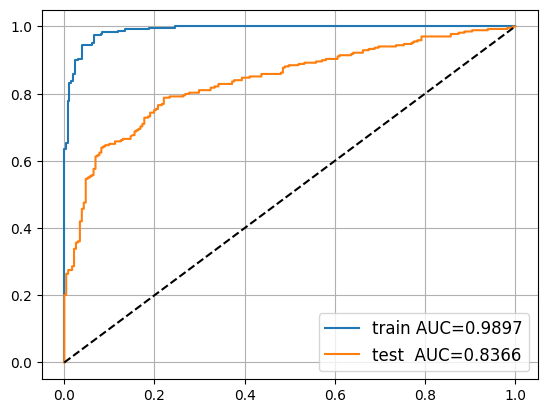

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

In [ ]:
probability_ratio = naive_model.p_x_given_positive / naive_model.p_x_given_negative
top_negative_words = [bow_vocabulary[i] for i in np.argsort(probability_ratio)[-25:]]

assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]
assert 'j.delanoy' in top_negative_words and 'college' in top_negative_words

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[bow_vocabulary.index(word)]})")

#0	scientific	(ratio=12.222967147827148)
#1	         @	(ratio=13.445263862609863)
#2	     idiot	(ratio=13.445263862609863)
#3	   bastard	(ratio=14.667561531066895)
#4	       hit	(ratio=14.667561531066895)
#5	         u	(ratio=15.278709411621094)
#6	   asshole	(ratio=15.889857292175293)
#7	         *	(ratio=17.11215591430664)
#8	   college	(ratio=17.11215591430664)
#9	         =	(ratio=17.53995704650879)
#10	    stupid	(ratio=18.33445167541504)
#11	       ass	(ratio=26.890527725219727)
#12	   fucking	(ratio=31.779714584350586)
#13	      shit	(ratio=44.002681732177734)
#14	      slap	(ratio=44.002681732177734)
#15	      fuck	(ratio=53.78105545043945)
#16	     bitch	(ratio=59.89254379272461)
#17	      fggt	(ratio=97.78373718261719)
#18	      dick	(ratio=187.0113983154297)
#19	 j.delanoy	(ratio=220.01341247558594)
#20	    nigger	(ratio=223.6802978515625)
#21	      suck	(ratio=314.7414245605469)
#22	   offfuck	(ratio=441.2491149902344)
#23	      heil	(ratio=471.8065185546875)
#24	    hitler

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression


param_grid = {
    'C': [0.01, 0.1, 1, 10], 
    'solver': ['liblinear', 'lbfgs', 'saga'], 
    'penalty': ['l1', 'l2'], 
    'max_iter': [100, 500, 1000]  
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_bow, y_train)

print("Best parameters:", grid_search.best_params_)

bow_model = grid_search.best_estimator_


/home/blx/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/blx/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/blx/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/blx/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/blx/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/blx/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarn

Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [21]:
bow_model = LogisticRegression(C=0.45, penalty='l2', solver="lbfgs", max_iter=100).fit(X_train_bow, y_train)

Model accuracy: 0.770
Well done!


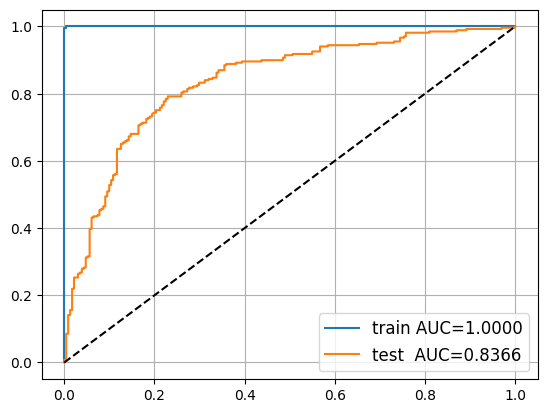

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy >= 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

In [23]:
my_idf_dict = {i:0 for i in bow_vocabulary}

N = len(texts_train)

for k, v in my_idf_dict.items():
    for j in texts_train:
        if k in j:
            my_idf_dict[k] += 1
            
for k, v in my_idf_dict.items():
    my_idf_dict[k] = np.log(N / my_idf_dict[k])

In [ ]:
def text_to_tfidf(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    
    my_dict = {i:0 for i in bow_vocabulary}
    
    for i in text.split():
        if i in my_dict.keys():
            my_dict[i] += 1
    
    for k, v in my_dict.items():
        my_dict[k] = my_dict[k] * my_idf_dict[k]
    
    return np.array(list(my_dict.values()), 'float32')

In [25]:
X_train_bow = np.stack(list(map(text_to_tfidf, texts_train)))
X_test_bow = np.stack(list(map(text_to_tfidf, texts_test)))

In [26]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

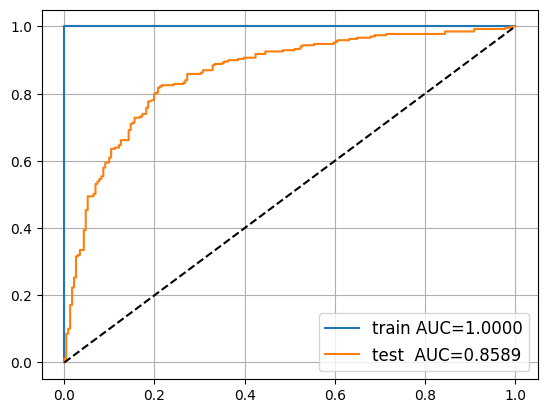

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

In [ ]:
import gensim.downloader 
embeddings = gensim.downloader.load("glove-wiki-gigaword-100")



[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def vectorize_sum(comment):

    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    
    for token in comment.split():
        if token in embeddings.key_to_index:
            features += embeddings[token]
    
    return features



In [ ]:
def vectorize_avg(comment):

    embedding_dim = embeddings.vectors.shape[1]
    features = np.zeros([embedding_dim], dtype='float32')
    count = 0 

    for token in comment.split():  
        if token in embeddings.key_to_index:  
            features += embeddings[token]  
            count += 1  

    if count > 0:
        features /= count  

    return features


In [44]:
X_train_wv = np.stack([vectorize_avg(text) for text in texts_train])
X_test_wv = np.stack([vectorize_avg(text) for text in texts_test])

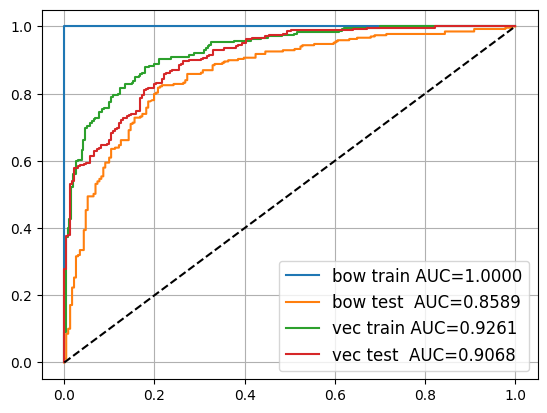

In [45]:
wv_model = LogisticRegression().fit(X_train_wv, y_train)

for name, X, y, model in [
    ('bow train', X_train_bow, y_train, bow_model),
    ('bow test ', X_test_bow, y_test, bow_model),
    ('vec train', X_train_wv, y_train, wv_model),
    ('vec test ', X_test_wv, y_test, wv_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

